# How to represent quantum systems using graphs
**Represent quantum systems for optimization, simulation, and other tasks using graphs**

The typical purpose of graph objects in Boulder Opal is to represent quantum systems.
The graph representation of such a system can be used to perform several tasks, including [robust control](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs) (for calculating optimized control pulses), [simulation](https://docs.q-ctrl.com/boulder-opal/tutorials/simulate-the-dynamics-of-a-single-qubit-using-computational-graphs) (to understand the dynamics of the system in the presence of specific controls and noises), and [system identification](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-perform-parameter-estimation-with-a-small-amount-of-data) (to estimate the values of unknown system parameters based on measurements of the system).

Please refer to our topic [Understanding graphs in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/) for context on what graphs are used for and why.

In what follows, we use graphs to define time-dependent Hamiltonians for simulation or optimization.
For information on how to use graphs for optimization tasks, see the user guide on [calculating and optimizing with graphs](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-calculate-and-optimize-with-graphs).

## Summary workflow

Here we outline the general procedure for representing your quantum systems and the computations performed on them in the form of graph objects.

### 1. Create graph inputs
For an optimization, these are optimizable variables that can be tuned by the optimizer to minimize a cost function.
For a simulation, the inputs can be known values for control pulses, or  quantities derived from known values.

### 2. Create signals
*Signals* are scalar-valued functions of time, which may be non-linear, have enforced temporal structure such as time symmetry, or more generally can depend arbitrarily on the inputs.
They only contain one numerical value in each period of time, which means their shape is zero-dimensional.
Signals represent the time-dependent envelope of the Hamiltonian.
You create piecewise-constant (PWC) signals using the `graph.pwc_signal` operation.

### 3. Create Hamiltonian operators
You create *operators* or PWC operator-valued (2D) functions of time by multiplying constant matrices (for example Pauli matrices) with signals.
Usually these operators represent individual terms in your Hamiltonian.
You can also create constant operators to represent static terms in your Hamiltonian.
Finally, you sum the individual operators created into a single Hamiltonian operator.

### 4. Add graph nodes representing computations on your quantum system
Once you have defined the nodes that describe your quantum system, you can add extra nodes representing the computations that you want to perform on it.
For example, Boulder Opal offers [time evolution operations](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/nodes#time-evolution), among many others.

Note that while this approach to constructing Hamiltonians is the most common, it is not a requirement.
You can use graphs to perform a wide variety of other computations too.
For example, Boulder Opal also provides specialized functions for working with trapped ions systems that take advantage of certain approximations to bypass Hamiltonian-level descriptions of the system (see the [How to design error-robust Mølmer–Sørensen gates for trapped ions](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-error-robust-molmer-sorensen-gates-for-trapped-ions) user guide for details).

## Example: Optimize a pulse to steer a qubit to a target dynamics

In this example, we will perform a simple optimization task for a quantum system using graphs. The system of interest is described by a Hamiltonian of the form
$$
H(t) = \frac{\omega_0}{2} \sigma_z + \alpha(t) \sigma_x + \beta(t) \sigma_z,
$$
where $\omega_0$ is the qubit frequency, $\alpha(t)$ is a time-dependent control, which we can optimize, and $\beta(t)$ is a dephasing noise process.
The dephasing amplitude is slowly varying so that you can assume it is constant at each different realization.

The goal of the optimization will be to remove the dephasing noise from the qubit by choosing an appropriate pulse $\alpha(t)$. Thus, the target unitary at the total duration time $T$ of the experiment is given by
$$
U_\mathrm{target}(T) = \exp \left(-i \frac{\omega_0}{2} T \sigma_z \right) = \cos \left( \frac{\omega_0}{2} T \right) I - i \sin \left( \frac{\omega_0}{2} T \right) \sigma_z .
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

In [2]:
# Define system parameters.

# Qubit frequency.
omega_0 = 2 * np.pi * 0.5e6  # rad/s

# Pulse parameters.
segment_count = 50
duration = 10e-6  # s

# Maximum value for |α(t)|.
alpha_max = 2 * np.pi * 0.25e6  # rad/s

In [3]:
# Create an empty graph.
graph = bo.Graph()

# Real PWC signal representing α(t).
alpha = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    duration=duration,
    minimum=-alpha_max,
    maximum=alpha_max,
    name="$\\alpha$",
)

# System Hamiltonian without dephasing.
hamiltonian = 0.5 * omega_0 * graph.pauli_matrix("Z") + alpha * graph.pauli_matrix("X")

# Dephasing noise amplitude.
beta = 2 * np.pi * 20e3  # rad/s

# (Constant) dephasing noise term.
dephasing = beta * graph.pauli_matrix("Z")

# Target operation.
target_operator = np.cos(0.5 * omega_0 * duration) * graph.pauli_matrix(
    "I"
) - 1j * np.sin(0.5 * omega_0 * duration) * graph.pauli_matrix("Z")

# Target operation node.
target = graph.target(operator=target_operator)

# Robust infidelity.
robust_infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian,
    noise_operators=[dephasing],
    target=target,
    name="robust infidelity",
)

Your task (action_id="1829135") is queued.
Your task (action_id="1829135") has started.
Your task (action_id="1829135") has completed.

Optimized robust cost: 1.114e-11


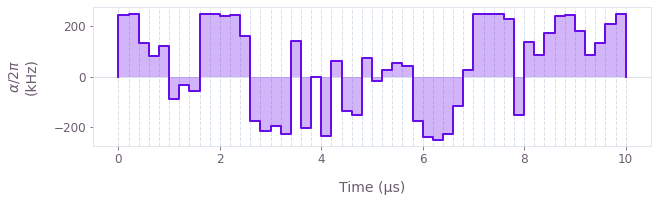

In [4]:
# Run the optimization and plot the results.

# Run the optimization.
optimization_result = bo.run_optimization(
    graph=graph, cost_node_name="robust infidelity", output_node_names="$\\alpha$"
)

# Print the optimized value of the cost function.
print()
print(f"Optimized robust cost: {optimization_result['cost']:.3e}")

# Plot the optimized control pulse.
qv.plot_controls(controls=optimization_result["output"])

## Example: Noisy qubit evolution

In this example, we will represent the following single qubit Hamiltonian as a graph
$$
H(t) = \frac{\Omega}{2} \sigma_x + \delta \sigma_z + \beta(t) \sigma_z,
$$
where $\Omega$ is the qubit Rabi frequency, $\delta$ is a detuning, and $\beta(t)$ is a random dephasing noise process induced by a classical bath.
We will model $\beta(t)$ as a Wiener process, which physically corresponds to Brownian noise, for example, through instrument errors.
The goal will be to simulate the qubit's noisy time evolution by using a graph.
For this purpose, we will add a node to the graph that computes random values corresponding to the Wiener process $\beta(t)$.
This is done by using the operations `graph.random.normal`, which produces random samples from a normal distribution, and `graph.cumulative_sum`, which adds to each element of a list the sum of all previous elements.

In [5]:
# Define system parameters.

# Simulation parameters.
segment_count = 200
duration = 30e-8  # s
sample_times = np.linspace(0.0, duration, segment_count)

# Physical system parameters.
Omega = 2 * np.pi * 10e6  # rad/s
delta = 2 * np.pi * 2e4  # rad/s
average_noise_strength = 2 * np.pi * 1.5e6  # rad/s

In [6]:
# Create an empty graph.
graph = bo.Graph()

# Add respective nodes to the graph.

# Create the Hamiltonian corresponding to the noiseless evolution.
noiseless_hamiltonian = graph.constant_pwc(
    constant=0.5 * Omega * graph.pauli_matrix("X") + delta * graph.pauli_matrix("Z"),
    duration=duration,
)

# Wiener process which models the dephasing noise.

# Compute random samples from a normal distribution.
samples = graph.random.normal(
    shape=(segment_count,),
    mean=0.0,
    standard_deviation=average_noise_strength,
    seed=0,
    name="samples",
)

# Build a Wiener process from the randomly chosen samples.
beta_values = graph.cumulative_sum(samples, name="beta values")

# Create a piecewise-constant signal from beta_vales.
beta_signal = graph.pwc_signal(
    values=beta_values, duration=duration, name="beta signal"
)

# Create a node corresponding to the dephasing Hamiltonian.
dephasing = beta_signal * graph.pauli_matrix("Z")

# Define the total Hamiltonian.
noisy_hamiltonian = noiseless_hamiltonian + dephasing

# Unitary time evolution generated by the total noisy Hamiltonian.
noisy_unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=noisy_hamiltonian, sample_times=sample_times, name="noisy unitaries"
)

# Initial state of the qubit, |0⟩.
initial_state = graph.fock_state(2, 0)[:, None]

# Evolved states, |ψ(t)⟩ = U(t) |0⟩.
evolved_noisy_states = noisy_unitaries @ initial_state
evolved_noisy_states.name = "noisy states"

Your task (action_id="1829136") has started.
Your task (action_id="1829136") has completed.

Final noisy unitary:
[[-0.694-0.053j -0.333+0.637j]
 [ 0.333+0.637j -0.694+0.053j]]

Final noisy state:
[[-0.694-0.053j]
 [ 0.333+0.637j]]


<IPython.core.display.Javascript object>

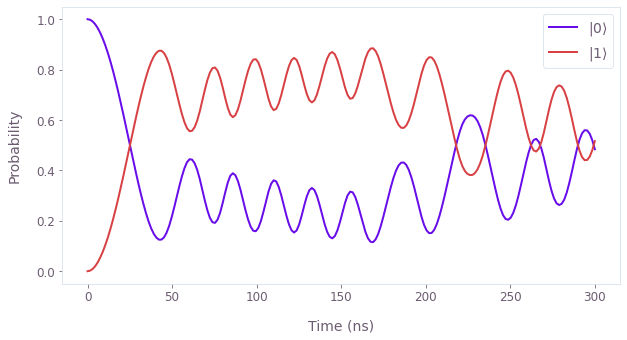

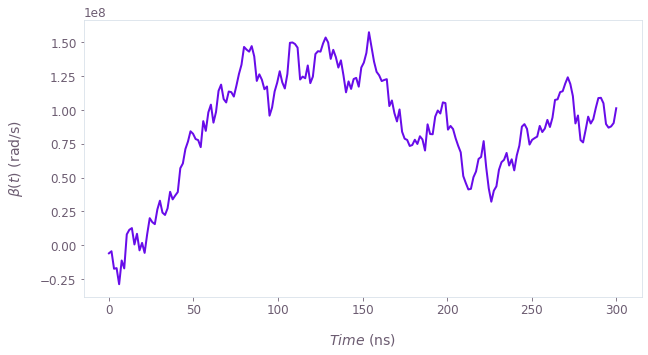

In [7]:
# Run the simulation and plot the results.

# Calculate the graph to obtain the unitaries.
result = bo.execute_graph(
    graph=graph, output_node_names=["noisy unitaries", "noisy states", "beta values"]
)

# Retrieve the results.
noisy_unitaries = result["output"]["noisy unitaries"]["value"]
noisy_states = result["output"]["noisy states"]["value"]

# Print the final unitary and final state of the time evolution.
print()
print(f"Final noisy unitary:\n{np.round(noisy_unitaries[-1], 3)}")
print()
print(f"Final noisy state:\n{np.round(noisy_states[-1], 3)}")

# Calculate qubit populations |⟨ψ|k⟩|².
noisy_qubit_populations = np.abs(noisy_states.squeeze()) ** 2

# Plot noisy populations.
qv.plot_population_dynamics(
    sample_times, {rf"$|{k}\rangle$": noisy_qubit_populations[:, k] for k in [0, 1]}
)

# Visualize noisy qubit dynamics on the Bloch sphere.
qv.display_bloch_sphere(noisy_states.squeeze())

# Retrieve noise values.
beta_values = result["output"]["beta values"]["value"]

# Create plot with the noise process.
plt.figure()
plt.plot(sample_times / 1e-9, beta_values)
plt.xlabel(r"$Time$ (ns)")
plt.ylabel(r"$\beta(t)$ (rad/s)")

plt.show()